# Traffic jams of gas molecules stabilise surface nanobubbles
#### Tan Beng Hau, Cavitation Lab

In this notebook I implement the numerical solution to the diffusion problem by Weijs and Lohse (PRL 110 054501 2013). Molecules of gas from the liquid can be regarded to pass through a layer of liquid of thickness $\ell$ and into the atmosphere. This is mediated by the diffusion equation

$$ \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial z^2}, $$ 

mediated by the boundary conditions

$$ c(z=0, t) = \frac{p_{\rm bub}}{k_H} = \frac{2\gamma}{k_H R} + \frac{P_{\rm atm}}{k_H},\;\;\; c(z=\ell,t) = \frac{P_{\rm atm}}{k_H}. $$

Fick's law gives 

$$ \frac{dN}{dt} = - AJ = -\pi(L^2 +h^2) D \frac{\partial c}{\partial z} \bigg\vert_{z=0}. $$

In this document I have diverged slightly from the approach of Weijs *et al*, who used a surface coverage factor $1/\rho$ in place of the area $A$. The factor $\rho$ in that paper represents the average bubble spacing. Nevertheless the two approaches will lead to largely the same lifetimes, as $O(L^2+h^2) \sim O(L^2) \sim O(1/\rho)$. The value of $\partial c/\partial z$ may be computed analytically from the diffusion equation, or numerically. In the numerical solution, we may *guess* that the initial concentration profile is linear, ie,

$$ c(z,t=0) = \frac{P_{\rm bub} - P_{\rm atm}}{k_H} \left( 1 - \frac{z}{\ell} \right) + \frac{P_{\rm atm}}{k_H}. $$

The number of gas molecules in the bubble follows the ideal gas law,

$$ \left( P_{\rm atm} + \frac{4\gamma h}{L^2 + h^2} \right) \frac{\pi h}{6}(3L^2 + h^2) = N k_B T. $$

Differentiating w.r.t. $h(t)$ gives 

$$ \frac{\pi}{6} (3L^2 + 3h^2 ) \left( P_{\rm atm} + \frac{4\gamma h}{L^2 + h^2} \right) \frac{dh}{dt}+ \frac{\pi h}{6}(3L^2 + h^2) \left( \frac{4\gamma}{L^2 + h^2} - \frac{8\gamma h^2}{(L^2 + h^2)^2} \right) \frac{dh}{dt} = \frac{dN}{dt} k_B T. $$

$$ \frac{\pi}{6 k_B T} f(L,h) \frac{dh}{dt} = - \pi(L^2 + h^2) D \frac{\partial c}{\partial z} \bigg\vert_{z=0}.$$ 

Then we have

$$ \frac{dh}{dt} = -6 k_B T D \frac{L^2 + h^2}{f(L,h)} \frac{\partial c}{\partial z}\bigg\vert_{z=0}, $$

where 

$$ f(L,h) = \left(3L^2 + 3h^2\right) \left( P_{\rm atm} + \frac{4\gamma h}{L^2 + h^2} \right)    + (3L^2 h+ h^3) \left( \frac{4\gamma}{L^2 + h^2} - \frac{8\gamma h^2}{(L^2 + h^2)^2} \right) .$$

At every time step, we therefore have 

$$ h^{n+1} = h^n - 6k_B T D \Delta t \frac{L^2 + h^2}{f(L,h)} \frac{\partial c}{\partial z} \bigg\vert_{z=0}. $$

** Numerical scheme**. The numerical solution uses the method of lines. Here, the space coordinate $z$ is discretised using centred finite differences, leading to an ordinary differential equation

$$\frac{\partial c}{\partial t} = \frac{D}{(\Delta z)^2} (c_{i-1}^n - 2c_i^n + c_{i+1}^n) $$

in the time coordinate $t$ which can be integrated using a standard (probably stiff) ODE solver. We only have to tweak the `diffusion` function in the code slightly to ensure that $c(z=0, t) = P_{\rm bub}/k_H$ and $c(z=\ell, t) = P_{\rm atm}/k_H$. To calculate the concentration gradient $\partial c/\partial z$ I used a higher order discretisation equation

$$ \frac{\partial c}{\partial z} \bigg\vert_{z=0} \approx \frac{ -c_3^n + 8c_2^n - 8 c_1^n + c_0^n }{12 \Delta z}, $$

though I think the most basic discretisation 

$$ \frac{\partial c}{\partial z} \bigg\vert_{z=0} \approx \frac{ c_1^n - c_0^n }{\Delta z} $$

will suffice.

As in Weijs and Lohse, the calculation is stopped when $h \sim 10^{-9}$ m.

In [2]:
from __future__ import division
from scipy import *
import matplotlib.pyplot as plt
from scipy import integrate
%matplotlib inline

In [74]:
D = 2e-9
kH = 2.6e-19
T = 300
R = 8.31
kB = 1.38e-23
Patm = 1e5
gamma = 72e-3

Nz = 300
Nt = 400000
ell = 1e-2
tll = 70000

dt = tll/Nt
dz = ell/Nz
lda = D*dt/(dz*dz)

h0 = 50e-9
L = 500e-9

c = zeros(Nz)
z = linspace(0,ell,Nz)

def Pbub(L,h):
    return Patm + 4*gamma*h / (L**2 + h**2)

def func(L,h):
    return (3*L**2 + 3*h**2) * (Patm + 4*gamma*h/(L**2 + h**2)) + (3*L**2 + h**2) *h* (4*gamma/(L**2 + h**2) - 8*gamma*h**2/((L**2 + h**2)**2) ) 

def diffusion(t,c, h):
    dcdt = zeros(Nz)
    dcdt[0] = D/(dz*dz) * (Pbub(L,h) / kH - 2*c[1] + c[2]) 
    dcdt[-1] = D/(dz*dz) * (Patm/kH - 2*c[Nz-2] + c[Nz-3]) 

    for i in range(1,Nz-1):
        dcdt[i] = D * (c[i+1] - 2*c[i] + c[i-1]) / (dz*dz) 
    
    return dcdt

k = 1
t = zeros((Nt,1))
h = zeros((Nt,1))
h[0]= h0
bubHeightNow = h0
c_initial = (Pbub(L,h0) - Patm) /kH * (1-z/ell) + Patm/kH

ode = integrate.ode(diffusion).set_integrator('vode', method='bdf', atol=1e-10)
ode.set_initial_value(c_initial, 0).set_f_params(h0)

c_out = zeros((Nz,Nt))
c_out[:,0] = c_initial

while ode.successful() and k < Nt and bubHeightNow > 1e-9:
    # Current nanobubble height   
    dcdz = (-ode.y[3] + 8*ode.y[2] -8*ode.y[1] + ode.y[0])/(12*dz)
    h[k] = h[k-1] + 6*kB*T*D*(L**2 + h[k-1]**2) / func(L,h[k-1]) * dt * dcdz
    c_out[:,k] = ode.y
    t[k] = ode.t
    bubHeightNow = h[k]

    # Method of lines
    ode.set_f_params(h[k]) # Change the b.c.
    ode.integrate(ode.t + dt)

    k += 1
    if k%5000==0: print k

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000


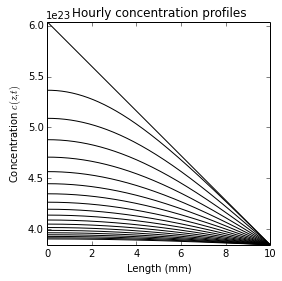

In [89]:
plt.figure(figsize=(4,4))
plt.title('Hourly concentration profiles')
plt.ylim([Patm/kH, Pbub(L,h0)/kH])
plt.xlabel('Length (mm)')
plt.ylabel('Concentration $c(z,t)$')

z_out = linspace(0,ell, Nz)
for i in range(Nt):
    if i%floor(Nt/tll * 3600) == 0:
        plt.plot(z_out/1e-3, c_out[:,i],'k')
        

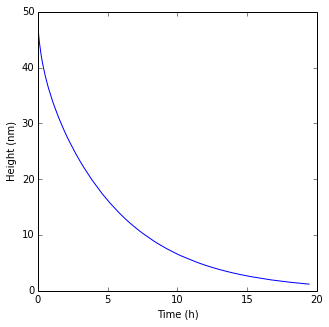

In [76]:
plt.figure(figsize=(5,5))
t = linspace(0,tll,Nt)
plt.plot(t/3600, h/1e-9)
plt.xlabel('Time (h)')
plt.ylabel('Height (nm)')